In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [10]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 224, 224 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

Xception_model = Xception(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

Xception_model.trainable=True

In [48]:
#for layer in Xception_model.layers[:-40]:
#    layer.trainable = False

In [6]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in Xception_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002004DBAF588>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002004DBCF388>,block1_conv1,True
2,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000020043BE1388>,block1_conv1_bn,True
3,<tensorflow.python.keras.layers.core.Activation object at 0x000002004DD1D808>,block1_conv1_act,True
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002004E528688>,block1_conv2,True
...,...,...,...
127,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x00000202E6DA8548>,block14_sepconv1_bn,True
128,<tensorflow.python.keras.layers.core.Activation object at 0x00000202E6DA32C8>,block14_sepconv1_act,True
129,<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x00000202E6DAC3C8>,block14_sepconv2,True
130,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x00000202E6DFF108>,block14_sepconv2_bn,True


In [7]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [28]:

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical 
from keras import optimizers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
# build model architecture 
model = Sequential()
model.add(Xception_model)
model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(num_class, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 200706    
Total params: 21,062,186
Trainable params: 21,007,658
Non-trainable params: 54,528
_________________________________________________________________
None


In [29]:
history = model.fit_generator(train, steps_per_epoch=64, 
                              epochs=10,  
                              validation_data=val,   
                              validation_steps=64,  
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 64 steps, validate for 64 steps
Epoch 1/10
64/64 [==============================] - 39s 611ms/step - loss: 0.4080 - accuracy: 0.9062 - f1_m: 0.9062 - precision_m: 0.9062 - recall_m: 0.9062 - val_loss: 0.3718 - val_accuracy: 0.9414 - val_f1_m: 0.9414 - val_precision_m: 0.9414 - val_recall_m: 0.9414
Epoch 2/10
64/64 [==============================] - 35s 542ms/step - loss: 0.3696 - accuracy: 0.9434 - f1_m: 0.9434 - precision_m: 0.9434 - recall_m: 0.9434 - val_loss: 0.3765 - val_accuracy: 0.9370 - val_f1_m: 0.9370 - val_precision_m: 0.9370 - val_recall_m: 0.9370
Epoch 3/10
64/64 [==============================] - 35s 546ms/step - loss: 0.3563 - accuracy: 0.9600 - f1_m: 0.9600 - precision_m: 0.9600 - recall_m: 0.9600 - val_loss: 0.3601 - val_accuracy: 0.9541 - val_f1_m: 0.9541 - val_precision_m: 0.9541 - val_recall_m: 0.9541
Epoch 4/10
64/64 [==============================] - 34s 534ms/step - loss: 0.3444 - accuracy: 0.9683 - f1_m

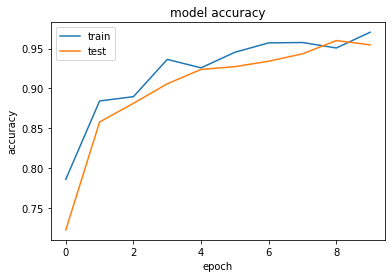

In [14]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

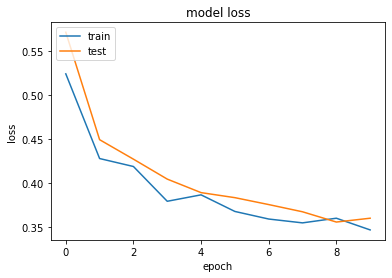

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

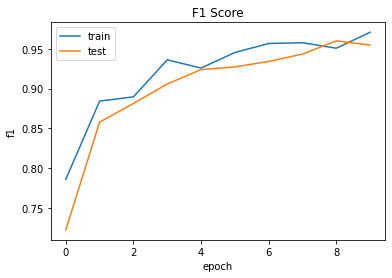

In [16]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

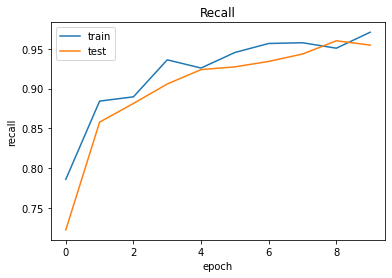

In [17]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

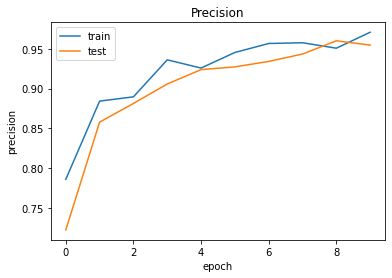

In [18]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

  ...
    to  
  ['...']
142/142 [==============================] - 15s 104ms/step - loss: 0.3513 - accuracy: 0.9596 - f1_m: 0.9596 - precision_m: 0.9596 - recall_m: 0.9596
El modelo predice el  95.96471786499023 % de los datos
